In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/netflix-data-aggregated.db')
netflix = pd.read_sql_query('select * from netflix', con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
netflix

,unit_id,dtime,address_v4,connect_time_v4,bytes_sec_v4,address_v6,connect_time_v6,bytes_sec_v6,delta_connect_time,delta_bytes_sec
0,123256,2016-07-22 00:00:00,198.38.119.140,20515,10371717,2a00:86c0:119:119::145,16803,10674265,3712,-302548
1,123256,2016-07-22 02:00:00,198.38.118.140,20570,10751181,2a00:86c0:119:119::142,17350,10958991,3220,-207810
2,123256,2016-07-22 04:00:00,198.38.119.149,15614,10388970,2a00:86c0:116:116::145,18747,9191069,-3133,1197901
3,123256,2016-07-22 10:00:00,198.38.119.149,18534,9844976,2a00:86c0:116:116::148,25121,8356098,-6587,1488878
4,123256,2016-07-22 13:00:00,198.38.117.153,23514,8260807,2a00:86c0:118:118::143,14076,10857188,9438,-2596381
...,...,...,...,...,...,...,...,...,...,...
969503,950234,2019-05-03 19:00:00,45.57.38.138,14564,116343808,2a00:86c0:2039:2039::142,11343,95874373,3221,20469435
969504,950234,2019-05-03 20:00:00,45.57.38.144,16070,112994705,2a00:86c0:2038:2038::141,9445,112935593,6625,59112
969505,950234,2019-05-03 21:00:00,45.57.38.136,8073,110344130,2a00:86c0:2038:2038::145,5363,98027453,2710,12316677
969506,950234,2019-05-03 22:00:00,45.57.39.143,14923,109319621,2a00:86c0:2038:2038::138,10461,110777402,4462,-1457781


In [5]:
netflix['connect_time_v4'] = netflix['connect_time_v4']/1000.0
netflix['connect_time_v6'] = netflix['connect_time_v6']/1000.0

In [6]:
netflix['dtime'] = netflix['dtime'].dt.floor('D')

In [7]:
df = netflix.groupby(['unit_id', 'dtime'], as_index=False
                         ).agg({'connect_time_v4' : 'median',
                                'connect_time_v6' : 'median'}
                              )

In [8]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [9]:
df

,unit_id,dtime,connect_time_v4,connect_time_v6,year,month
0,62712,2017-01-31,4.3165,18.5575,2017,1
1,62712,2017-02-01,8.4315,19.4505,2017,2
2,62712,2017-02-02,4.4990,18.8600,2017,2
3,62712,2017-02-03,4.2550,18.9210,2017,2
4,62712,2017-02-04,4.5720,18.6070,2017,2
...,...,...,...,...,...,...
48839,950240,2017-08-08,7.3710,7.2720,2017,8
48840,950240,2017-08-09,7.4810,7.6440,2017,8
48841,950240,2017-08-10,7.7260,7.2250,2017,8
48842,950240,2017-08-11,7.5135,7.7325,2017,8


In [10]:
by_years = df.groupby('year')

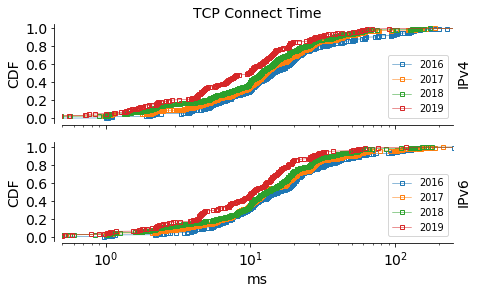

In [11]:
cdf_fig, (cdf_v4_ax, cdf_v6_ax) = plt.subplots(figsize = (7, 4), nrows=2)

cdfs = []

for year, year_df in by_years:
    v4 = Cdf.MakeCdfFromList(year_df['connect_time_v4'])
    v6 = Cdf.MakeCdfFromList(year_df['connect_time_v6'])

    cdf_v4_ax.plot(v4.xs, v4.ps, label = year, marker = 's',
                   linewidth = 0.5, markersize = 3.5, fillstyle = 'none',
                   markevery=15)
    cdf_v6_ax.plot(v6.xs, v6.ps, label = year, marker = 's',
                   linewidth = 0.5, markersize = 3.5, fillstyle = 'none',
                   markevery=15)

    cdfs.append((year, 'IPv4', v4))
    cdfs.append((year, 'IPv6', v6))

for cdf_ax, version in [(cdf_v4_ax, 'IPv4'), (cdf_v6_ax, 'IPv6')]:
    cdf_ax.set_ylim([-0.05, 1.05])
    cdf_ax.set_xlabel('ms')
    cdf_ax.set_ylabel('CDF')
    cdf_ax.set_xlim([0.5, 250])
    cdf_ax.set_xscale('log')

    cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')

    yticks = np.arange(0.0, 1.01, 0.2)
    cdf_ax.set_yticks(yticks)
    cdf_ax.grid(False)
    cdf_ax.spines['right'].set_color('none')
    cdf_ax.spines['top'].set_color('none')
    cdf_ax.yaxis.set_ticks_position('left')
    cdf_ax.xaxis.set_ticks_position('bottom')
    cdf_ax.spines['bottom'].set_position(('axes', -0.02))
    cdf_ax.spines['left'].set_position(('axes', -0.02))
    
    ax1_ = cdf_ax.twinx()
    ax1_.spines['right'].set_color('none')
    ax1_.spines['top'].set_color('none')
    ax1_.spines['left'].set_color('none')
    ax1_.spines['bottom'].set_color('none')
    ax1_.yaxis.set_ticks_position('none')
    ax1_.set_ylabel('%s' % version)
    plt.setp(ax1_.get_yticklabels(), visible = False)

cdf_v4_ax.set_xticklabels('')
cdf_v4_ax.set_xlabel('')
cdf_v4_ax.set_title('TCP Connect Time')

cdf_fig.savefig('../plots/tcp-conn-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [12]:
print('TCP CONNECT TIME')
print('----------------')
for year, version, cdf in cdfs:
    print(year, '\t', version)
    print('----------------')
    skip = int(len(cdf.xs)/150)
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f \t %.5f' % (x, p))
    print('\n===========================\n')

TCP CONNECT TIME
----------------
2016 	 IPv4
----------------
0.35 	 0.00023
1.04 	 0.00733
1.09 	 0.01501
1.96 	 0.02246
2.03 	 0.02933
2.09 	 0.03712
2.17 	 0.04469
3.04 	 0.05086
3.71 	 0.05761
3.77 	 0.06505
3.83 	 0.07401
3.95 	 0.08216
4.11 	 0.08903
4.59 	 0.09508
4.79 	 0.10113
4.91 	 0.10741
5.10 	 0.11405
5.25 	 0.12196
5.31 	 0.13057
5.36 	 0.13814
5.43 	 0.14547
5.56 	 0.15245
5.71 	 0.15978
5.99 	 0.16607
6.07 	 0.17293
6.21 	 0.17956
6.35 	 0.18597
6.66 	 0.19202
6.78 	 0.19923
6.89 	 0.20621
7.13 	 0.21250
7.37 	 0.21948
7.41 	 0.23426
7.51 	 0.24113
7.72 	 0.24799
8.00 	 0.25404
8.48 	 0.26010
8.72 	 0.26673
8.87 	 0.27336
9.14 	 0.27988
9.39 	 0.28640
9.65 	 0.29245
9.90 	 0.29873
10.01 	 0.30548
10.07 	 0.31374
10.13 	 0.32108
10.20 	 0.32992
10.29 	 0.33655
10.43 	 0.34319
10.54 	 0.35017
10.64 	 0.35738
10.71 	 0.36390
10.81 	 0.37042
10.92 	 0.37717
11.03 	 0.38334
11.16 	 0.39032
11.27 	 0.39672
11.41 	 0.40312
11.60 	 0.40964
11.84 	 0.41615
12.05 	 0.42220
12.2

4.22 	 0.18904
4.31 	 0.19501
4.37 	 0.20125
4.40 	 0.20884
4.41 	 0.21861
4.44 	 0.22620
4.46 	 0.23325
4.52 	 0.24030
4.55 	 0.24681
4.59 	 0.25414
4.63 	 0.26065
4.72 	 0.26661
4.78 	 0.27366
4.81 	 0.28072
4.95 	 0.28695
5.66 	 0.29292
5.88 	 0.29916
5.94 	 0.30567
6.06 	 0.31245
6.25 	 0.31896
6.75 	 0.32493
6.94 	 0.33116
7.07 	 0.33713
7.13 	 0.34391
7.20 	 0.35042
7.27 	 0.35801
7.32 	 0.36425
7.38 	 0.37130
7.52 	 0.37727
7.94 	 0.38324
8.09 	 0.38921
8.43 	 0.39544
8.70 	 0.40168
8.79 	 0.40765
8.87 	 0.41389
9.03 	 0.41985
9.19 	 0.42582
9.48 	 0.43179
9.62 	 0.43830
9.70 	 0.44453
9.76 	 0.45050
9.81 	 0.45728
9.91 	 0.46352
9.96 	 0.47003
10.02 	 0.47600
10.13 	 0.48196
10.28 	 0.48820
10.40 	 0.49417
10.48 	 0.50068
10.57 	 0.50692
10.66 	 0.51315
10.76 	 0.51912
10.86 	 0.52536
11.01 	 0.53160
11.15 	 0.53784
11.50 	 0.54380
12.00 	 0.54977
12.23 	 0.55574
12.33 	 0.56225
12.41 	 0.56848
12.55 	 0.57472
12.69 	 0.58096
12.75 	 0.58747
12.78 	 0.59425
12.84 	 0.60049
13.1